In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import random
from collections import Counter
import itertools
import math

import networkx as nx
import numpy as np
import pandas as pd
from scipy.special import softmax
from tqdm import trange, tqdm
import matplotlib as mpl

from models.single_step import Car, TrafficModel, run
from util.network import create_braess_network
from util.analysis import plot_social_welfare, plot_travel_time_per_route, plot_cars_per_edge, plot_cars_per_route, draw_edge_utilization, draw_latency_params, plot_latency_increase_per_edge
from util.tolling import update_tolls

In [52]:
number_of_cars = 20
number_of_steps = 20

network = create_braess_network()
cars = {id: Car(0, 3) for id in range(number_of_cars)}

model = TrafficModel(network, cars)

model.set_edge_restriction((1, 2), allowed=False)
step_stats, car_stats = run(model, number_of_steps, verbose=False)

100%|██████████| 20/20 [00:00<00:00, 1130.27it/s]


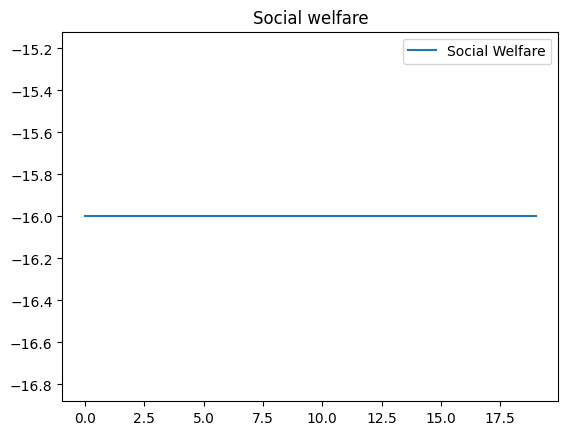

In [53]:
plot_social_welfare(step_stats)

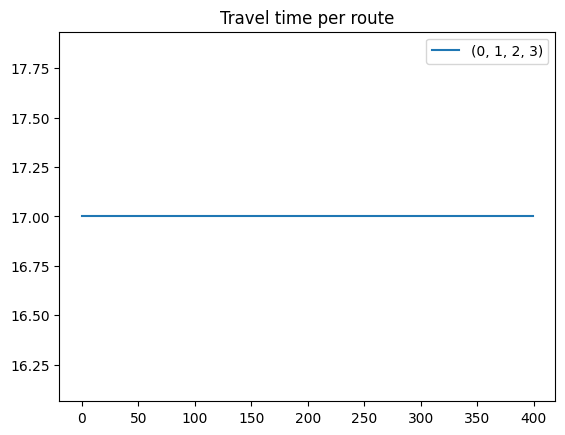

In [36]:
plot_travel_time_per_route(car_stats)

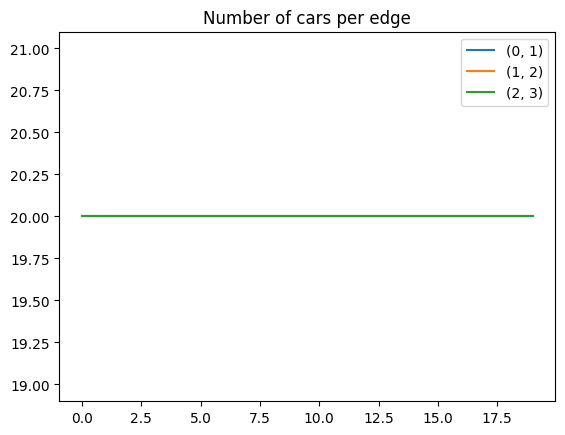

In [37]:
plot_cars_per_edge(car_stats)

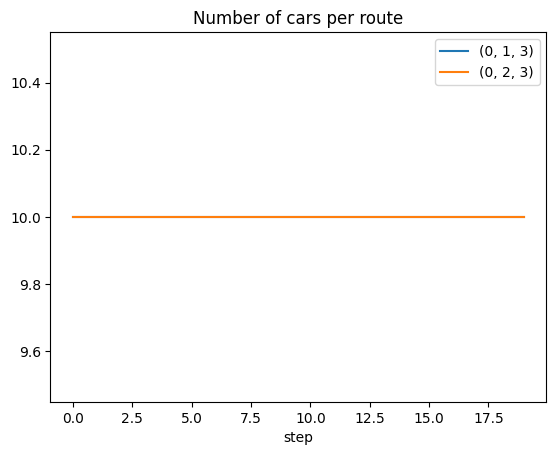

In [56]:
plot_cars_per_route(car_stats)

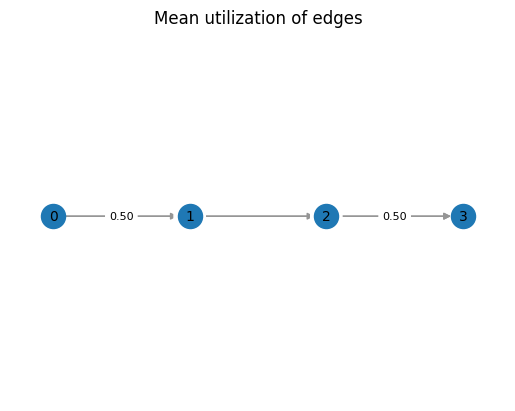

In [55]:
draw_edge_utilization(model, car_stats)

KeyError: 0

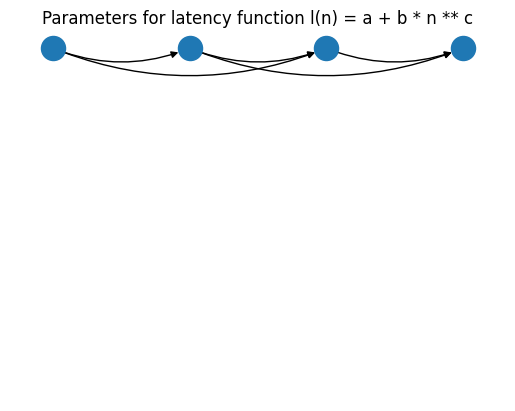

In [44]:
draw_latency_params(model)

{(0, 1): 5.0, (0, 2): 11.0, (1, 2): 1.0, (1, 3): 11.0, (2, 3): 5.0}

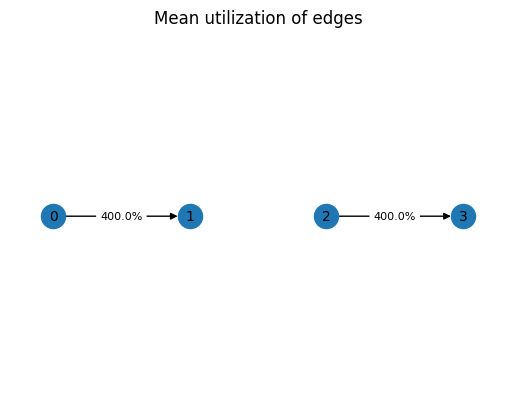

In [54]:
plot_latency_increase_per_edge(model, step_stats)

## Delta-tolling

In [ ]:
def run(model, number_of_steps, verbose=False):
    routes = {id: [] for id in model.cars}

    nx.set_edge_attributes(model.network, 0, "utilization")
    model.update_latencies()

    step_stats = []
    car_stats = []
    for step in (range if verbose else trange)(number_of_steps):
        if verbose:
            print(f"Step {step}:")
            print(
                f'Initial latency = {nx.get_edge_attributes(model.network, "latency")}'
            )

        for id, car in np.random.permutation(list(model.cars.items())):
            for edge in zip(routes[id], routes[id][1:]):
                model.decrease_utilization(edge)

            # Let agents choose a route, given the network with allowed edges only
            routes[id] = car.act(model.allowed_network, verbose=verbose)

            for edge in zip(routes[id], routes[id][1:]):
                model.increase_utilization(edge)

        step_stats.append(
            list(routes.values())
            + list(nx.get_edge_attributes(model.network, "latency").values())
            + list(nx.get_edge_attributes(model.network, "toll").values())
            + [
                nx.path_weight(model.network, route, "latency")
                for car_id, route in routes.items()
            ]
        )

        for id, car in model.cars.items():
            car_stats.append(
                {
                    "step": step,
                    "car_id": id,
                    "source": car.source,
                    "target": car.target,
                    "route": tuple(routes[id]),
                    "travel_time": nx.path_weight(model.network, routes[id], "latency"),
                }
            )

        update_tolls(model.network, beta=1, R=0.1)

    return pd.DataFrame(
        step_stats,
        columns=pd.MultiIndex.from_tuples(
            [("route", car_id) for car_id in model.cars]
            + [("latency", car_id) for car_id in model.network.edges]
            + [("travel_time", car_id) for car_id in model.cars]
        ),
    ), pd.DataFrame(car_stats)

In [ ]:
number_of_cars = 20
number_of_steps = 20

network = create_braess_network()
cars = {id: Car(0, 3) for id in range(number_of_cars)}

model = TrafficModel(network, cars)

model.set_edge_restriction((1, 2), allowed=False)
